# Extracting Features BERT

### Setup

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
%run -i 'random_state.py'
from packages import *
from clean_functions import *

Using TensorFlow backend.


### Loading BERT

In [3]:
%%time

bert_tokenizer = BertTokenizer.from_pretrained('models/', do_lower_case=False)
bert_model = BertModel.from_pretrained('models/').to(device)

CPU times: user 3.25 s, sys: 1.5 s, total: 4.75 s
Wall time: 8.22 s


### Preparing datasets

In [4]:
with open("data/mov.txt", "rb") as fp:   # Legal proceedings
    mov = pickle.load(fp)

with open("data/tags.txt", "rb") as fp:   # Tags
    tags = pickle.load(fp)

Letting motions in cronological order:

In [5]:
mov[0][:4]

[['14-11-2018',
  'Tipo do Movimento:Ato Ordinatório Praticado Descrição:Certifico e dou fé que as custas pendentes de fls 685 não foram recolhidas pelas parte GILMAR RODRIGUES REGO e BRUNO MEDEIROS.'],
 ['23-07-2018',
  'Tipo do Movimento:Juntada - Petição Descrição da juntada:Documento eletrônico juntado de forma automática.'],
 ['16-07-2018',
  'Tipo do Movimento:Publicado\xa0 Atos da Serventia Folhas do DJERJ.:388/416'],
 ['29-06-2018', 'Tipo do Movimento:Enviado para publicação ']]

In [6]:
for m in mov:
    m.reverse()

In [7]:
mov[0][:4]

[['10-09-2010',
  'Tipo do Movimento:Distribuição Sorteio Serventia:Cartório da 34ª Vara Cível - 34ª Vara Cível'],
 ['21-09-2010',
  'Tipo do Movimento:Conclusão ao Juiz Juiz:JOAO MARCOS DE CASTELLO BRANCO FANTINATO'],
 ['23-09-2010',
  'Tipo do Movimento:Despacho - Proferido despacho de mero expediente Descrição:Defiro JG. \r\n\r\nIndefiro a antecipação dos efeitos da tutela, eis que as alegações do autor carecem de dilação probatória.\r\n\r\nCite-se.'],
 ['23-09-2010', 'Tipo do Movimento:Enviado para publicação ']]

Cleaning texts

In [8]:
%%time

for i in range(len(mov)):
    for j in range(len(mov[i])):
        mov[i][j][1]=clean_bert(mov[i][j][1])

CPU times: user 1min 55s, sys: 70.9 ms, total: 1min 55s
Wall time: 1min 55s


### Defining some functions

In [9]:
def get_X_y_bert(mov, tags, len1=5, embed_dim=768):
    
    #len1: let's take the last l1 motions in each proceeding
    
    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),len1,embed_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-len1::] #let's take the last l1 motions in each proceeding

        for j in range(len(mov[i])):
            tokens=torch.tensor(bert_tokenizer.encode(mov[i][j][1], add_special_tokens=True, max_length=512)).unsqueeze(0).to(device)
            
            bert_model.eval()
            with torch.no_grad(): temp=bert_model(tokens)[1].cpu().numpy().reshape(-1)
            
            X[cont][j][:np.shape(temp)[0]]=temp

        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

### Exploring data

Let's evaluate the distribution of motion quantities per proceeding.

In [10]:
%%time

leng1=[]
for i in range(len(mov)):
    leng1.append(len(mov[i]))

CPU times: user 4.78 ms, sys: 0 ns, total: 4.78 ms
Wall time: 4.74 ms


In [11]:
%%time

dist1=[]
leng1=np.array(leng1)

for i in range(300):
    dist1.append([i,np.mean(leng1<=i)])
    
dist1=np.array(dist1)

CPU times: user 7.31 ms, sys: 0 ns, total: 7.31 ms
Wall time: 6.84 ms


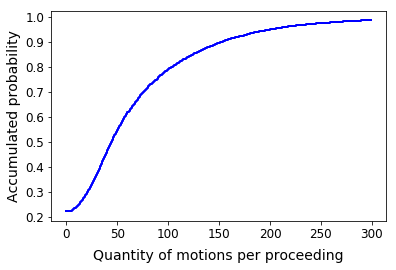

In [12]:
plt.step(dist1[:,0],dist1[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', size=14)
plt.xlabel('Quantity of motions per proceeding', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_mov.png", facecolor='white', dpi=100)
plt.show()

### Getting the data and saving it

In [13]:
%%time

len1=5 #vamos pegar somente as últimas len1 movimentações

X,y=get_X_y_bert(mov,tags,len1)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded
40.0 % concluded
60.0 % concluded
80.0 % concluded
100.0 % concluded
CPU times: user 5min 35s, sys: 453 ms, total: 5min 36s
Wall time: 5min 36s


In [14]:
X.shape

(6449, 5, 768)

Saving data

In [15]:
np.save('data/X_bert.npy', X)
np.save('data/y_bert.npy', y)